# Visualização das Imagens depois da transformação, mas antes da classificação do modelo
As imagens no meio são as atuais (current), as na esquerda são as anteriores (previous) à atual e as na direita são as imagens seguintes (next).

In [1]:
## Imports - 

import json
import math
import random
import re
import time

from types import SimpleNamespace

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
from model_interface import TrainingPipeline
from nn_modules import ThreePagesEffModule
from PIL import Image
from skimage import io as skio
from skimage import transform
from sklearn import decomposition, manifold
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from timm.optim import optim_factory
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler


In [2]:
## Resize - OK

pretrained_size = (224,224)
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

class ResizeBinarize(object):
    def __call__(self, image):
        if len(image.shape)>2:
            image=image[0,:,:]
        resized = cv2.resize(image, (224,224), interpolation = cv2.INTER_CUBIC)
        retval,bin = cv2.threshold(resized,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return bin

In [3]:
## Dataset
    
class ThreePagesTobaccoDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir=root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        label2Idx = {'single page': 3,'first of many': 2,'middle': 1,'last page':0}
        if type(index) != int:
            i = index.item()
        else: i = index
            
        row = self.dataframe.iloc[index]
        file_name = row["docid"]+'.tif'
        target_page = skio.imread(self.root_dir+file_name,plugin='pil')
        label = row['extended_class']        
        
        if index < 1:
            next_row = self.dataframe.iloc[index+1]
            prev_page = np.full_like(target_page, 255)
            next_name = next_row["docid"]+'.tif'
            next_page = skio.imread(self.root_dir+next_name,plugin='pil')
        elif index >= len(self.dataframe) - 1:
            prev_row = self.dataframe.iloc[index-1]
            next_page = np.full_like(target_page, 255)
            prev_name = prev_row["docid"]+'.tif'
            prev_page = skio.imread(self.root_dir+prev_name,plugin='pil')
        else:
            prev_row = self.dataframe.iloc[index-1]
            next_row = self.dataframe.iloc[index+1]
            prev_name = prev_row["docid"]+'.tif'
            prev_page = skio.imread(self.root_dir+prev_name,plugin='pil')
            next_name = next_row["docid"]+'.tif'
            next_page = skio.imread(self.root_dir+next_name,plugin='pil')            
                    
        if self.transform:
            target_page = self.transform(target_page)
            prev_page = self.transform(prev_page)
            next_page = self.transform(next_page)
            
        return (
            [prev_page, target_page, next_page],
            label2Idx[label],
            file_name
        )

In [4]:
# View Images

label_path="/mnt/home/leao.victor/splitter-dados/model-fourclass/splitter-osiris/splitter_four_class.csv"
page_imgs_path="/mnt/home/leao.victor/splitter-dados/model-fourclass/splitter-osiris/new_tif/"
test_size=0.33
val_size=0.2

df = pd.read_csv(
        label_path, sep=",", skiprows=0, low_memory=False
    )
        
df_train, df_test = train_test_split(
        df, test_size=test_size, random_state=42
    )

df_test, df_val = train_test_split(
        df_test, test_size=val_size, random_state=42
    )

label2Idx = {'single page': 3,'first of many': 2,'middle': 1,'last page':0}


transform = transforms.Compose(
    [
        ResizeBinarize(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
    ]
)

train_data = ThreePagesTobaccoDataset(
    df_train, page_imgs_path, transform
)

valid_data = ThreePagesTobaccoDataset(
    df_val, page_imgs_path, transform
)

test_data = ThreePagesTobaccoDataset(
    df_test, page_imgs_path, transform
)

In [5]:
## Images Visualization
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def concat_images(imga, imgb, imgc):
    """
    Combines three color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    hc,wc = imgc.shape[:2]
    max_height = np.max([ha, hb, hc])
    total_width = wa+wb+wc
    new_img = np.zeros(shape=(max_height, total_width, 3))
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    new_img[:hc,wa+wb:wa+wb+wc]=imgc
    return new_img
    

def plot_images(images, labels, classes, file_names, normalize = True):

    n_images = len(labels)

    rows = n_images
    cols = 1

    fig = plt.figure(figsize = (100, 100))

    for i in range(rows*cols):
        
        prev_image = images[i][0]
        curr_image = images[i][1]
        next_page = images[i][2]

        ax = fig.add_subplot(rows, cols, i+1)
        
        if normalize:
            prev_image = normalize_image(prev_image)
            curr_image = normalize_image(curr_image)
            next_page = normalize_image(next_page)

        prev_image = prev_image.permute(1, 2, 0).cpu().numpy()    
        curr_image = curr_image.permute(1, 2, 0).cpu().numpy()
        next_page = next_page.permute(1, 2, 0).cpu().numpy()

        ax.imshow(concat_images(prev_image, curr_image, next_page))
        ax.set_title(f'{classes[labels[i]]}\n' \
                     f'{file_names[i]}')   
        ax.axis('off')

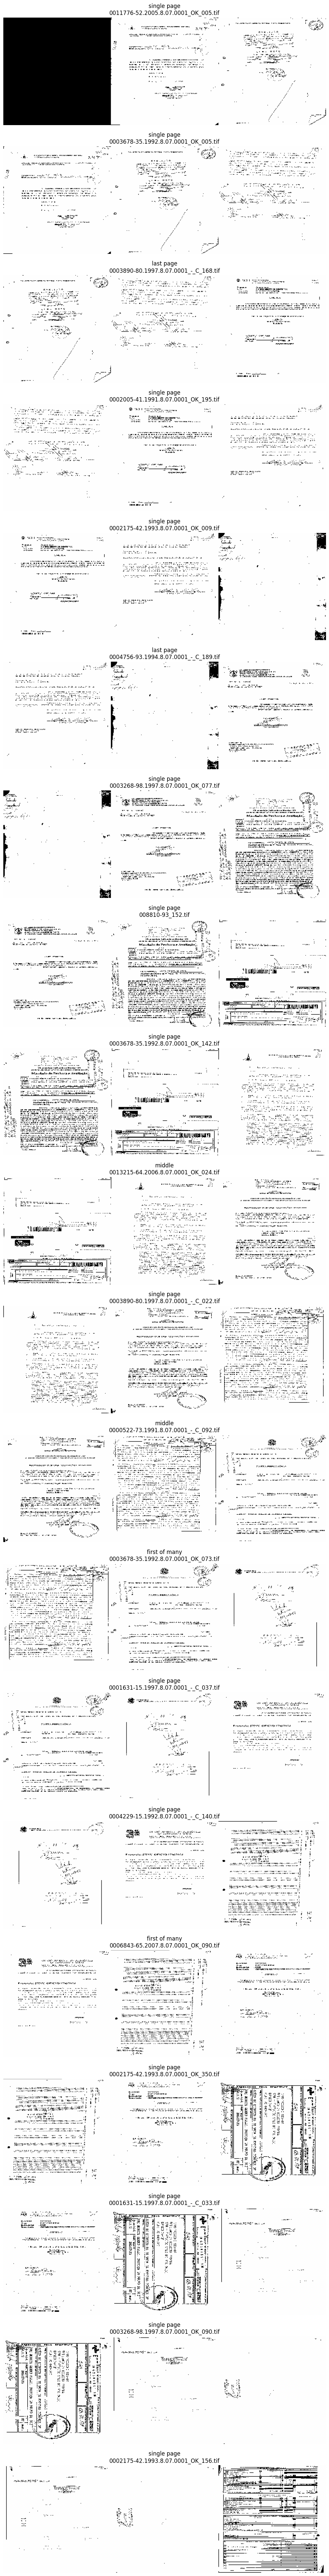

In [6]:
N_IMAGES = 20

images, labels, file_names = zip(*[(image, label, file_name) for image, label, file_name in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = {3: 'single page',2: 'first of many',1:'middle',0:'last page'}

#prev_images, curr_images = images[0]

plot_images(images, labels, classes, file_names)